# Внутренние устройства типов данных для математических вычислений Python, Numpy, Pytorch.

**Статья основана на второй главе этой <a href="https://github.com/jakevdp/PythonDataScienceHandbook">книги</a> (Introduction to NumPy), но дополнена уточнениями и расширенна главой про broadcasting. Книжка очень хорошая. :-)**

## Подключение библиотек

In [1]:
from simple_benchmark import benchmark
import time
import numpy as np
import sys

## Введение 

При анализе данных приходится иметь дело с числовыми массивами огромных размеров.  Для того, чтобы математические операции занимали минимальное количества времени и памяти необходимо понимание внутреннего устройства структур, использующихся для хранения и манипуляций с ними.  

## Типы данных в Python

Python в отличии от С++ и Java является не строго типизированном языком программирования, что дает ему огромную гибкость. 

**Пример**

```c++
/* C code */
int result = 0;
for(int i=0; i<100; i++){
    result += i;
}
```

```python
# Python code
result = 0
for i in range(100):
    result += i
```

Ключевое отличие в том, что в С++ тип каждой переменной определяется при ее создании и не может быть изменен в дальнейшим. В Python же тип переменной определяется динамически, во время выполнения. Это означает, что мы можем присвоить переменной данные любого типа, меняя при этом тип самой переменной.  

**Пример**

In [2]:
var = 3; print(type(var)) #Создали переменную типа int 

<class 'int'>


In [3]:
var = '3'; print(type(var)) #Меняем значения и тип переменной 

<class 'str'>


На С++ такие манипуляции просто невозможны.

```c++
/* C code */
int result = 0;
result = "Ноль"; # Вызовет ошибку так, как result не строка, а число  
```

Понимание этого очень важно для эффективной манипуляции данными в data science.

## Внутренние устройство типа Integer в Python

Python написан на языке С и каждый тип данных в нем является классом в Python.

In [4]:
print(type(0)); print(type(0.8)); print(type("ooo"));

<class 'int'>
<class 'float'>
<class 'str'>


В то время как на стороне С каждый тип приставляет из себя структуру, содержащую набор полей.

Итак, **var = 10** не просто переменная типа integer, это указатель на структуру языка С. Рассмотрим подробно эту структуру. 

```c++
struct _longobject {
    long ob_refcnt;
    PyTypeObject *ob_type;
    size_t ob_size;
    long ob_digit[1];
};
```

- Поле ob_refcnt - счетчик ссылок, необходим Python для управления памятью 
- Поле ob_type - кодирует тип (integer в нашем случаи)
- Поле ob_type - количество элементов в массиве ob_digit (необходим для длинной арифметики. Подробно описан <a href="https://www.codementor.io/@arpitbhayani/how-python-implements-super-long-integers-12icwon5vk">здесь</a>)
- Поле ob_type - непосредственно наши данные 

Именно благодаря этим дополнительным полям  Python является не строго типизированным языком.

Если сравнивать integer в С++ с integer в python, вырисовывается следующая картина. 

![cint_vs_pyint](images/type_of_datas_and_broadcasting/cint_vs_pyint.png)

Здесь PyObject_HEAD — структура, содержащая все ранее упомянутые поля: ob_refcnt, ob_type и т. д. 

### Вывод

В С++ integer — это просто указатель на область памяти, содержащий значении переменной, тогда как в Python  integer — указатель на область памяти, содержащую Python объект, который помимо значения переменной содержит множество дополнительных полей. Такое представление переменных избыточно и особенно это будет заметно когда таких переменных будет тысячи, а то и десятки тысячи.

## Внутреннее устройства типа list в Python 

Допустим у нас есть dataset с числами и мы решили заняться его анализом. Первое, что нужно сделать — это выбрать структуру данных для их хранения. Давайте разберемся почему список не лучшее решения. 

Заполнить список числами можно так:

In [5]:
L = [1,2,3,4]

In [6]:
type(L[0])

int

или так

In [7]:
L = ['1','2','3','4']

In [8]:
type(L[0])

str

Либо даже так

In [9]:
L = [1,'2', 0.6, True]

In [10]:
[print(type(l)) for l in L]

<class 'int'>
<class 'str'>
<class 'float'>
<class 'bool'>


[None, None, None, None]

Видно, что список поддерживает динамическую типизацию. Помимо структуры описывающей тип списка: счетчика ссылок, длины и т. д. он также хранит указатели на каждый элемент, а элемент в свою очередь, является Python объектом со своим счетчиком ссылок, длиной и т. д. 

![list](images/type_of_datas_and_broadcasting/List.png)

### Вывод

Если мы хотим анализировать данные определенного типа, то структура где каждый элемент хранит свой тип избыточна. Гораздо выгодней хранить общий тип всех элементов отдельно. Помимо этого, элементы списка разбросаны по памяти и каждый раз, обращаясь к элементу, мы берем его указатель, переходим по адресу хранящимся в нем, извлекаем объект и лишь в конце получаем значение. Такой способ излечения значения будет серьезно тормозить программу, анализирующую большие данные.

Давайте попробуем устранить указанный недостатки.

## Python array

Начиная с версии 3.3 в Python появился встроенный тип данных array, который посути является обверткой над массивами языка С. Рассмотрим его структуру. 

![python_array](images/type_of_datas_and_broadcasting/python_array.png)

Все элементы в нем имеют одинаковый тип, который задается при создании объекта и не может быть изменен в дальнейшим

In [11]:
import array

In [12]:
L = [1,2,3,4]

In [13]:
arr = array.array('i',L) 

In [14]:
arr

array('i', [1, 2, 3, 4])

Здесь i — это код типа данных языка С (integer). Также доступны другие типы (см. <a href="https://docs.python.org/3/library/array.html">здесь</a>)

```python
arr[0] = 'l' # Вызовет ошибку неверный тип 
````

Благодаря тому, что общий тип храниться в одном месте экономиться значительное количество памяти. 

In [15]:
L = list(range(1000))
A = array.array('i', L)

In [16]:
print(type(L[0])); print(type(A[0])); # Типы идентичны 

<class 'int'>
<class 'int'>


In [17]:
sys.getsizeof(L)

8056

In [18]:
sys.getsizeof(A)

4064

In [19]:
sys.getsizeof(L) / sys.getsizeof(A) # Меньше почти в 2 раза 

1.9822834645669292

Может показаться, за счет того, что данные хранятся в упакованном виде, значительно быстрее происходит извлечения значения из памяти, но это не так.

In [20]:
%%timeit 
result = 0
for i in A:
    result += i 

37.2 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
%%timeit 
result = 0
for i in L:
    result += i

29.8 µs ± 427 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Чтобы найти причину задержки, обратимся к исходному коду функций извлекающих значения. 

Функция списка 

```C++
PyObject *
PyList_GetItem(PyObject *op, Py_ssize_t i)
{
    /* error checking omitted */
    return ((PyListObject *)op) -> ob_item[i];
}
```

Функция массива

```C++
static PyObject *
l_getitem(arrayobject *ap, Py_ssize_t i)
{
    return PyLong_FromLong(((long *)ap->ob_item)[i]);
}
```

В отличии от списка, при извлечении значения из массива на стороне С создается Python объект. Это абсолютно необходимо, так как Python может работать только с объектами. Именно эта операция так сильно тормозит массивы. (Подробнее <a href=»https://stackoverflow.com/questions/36778568/why-are-pythons-arrays-slow»>здесь</a>)

Еще один недостаток связан с переполнением. В типах с фиксированным размерам нет длинной арифметики.  

In [22]:
max_value = 2_147_483_647

In [23]:
A[0] = max_value; L[0] = max_value 

A[0] += 1 # Вызовет ошибку переполнения 

In [24]:
L[0] += 1 # Длинная арифметика, поле ob_size увеличилось на единицу. 

In [25]:
L[0]

2147483648

### Вывод

Для эффективной манипуляции числовыми данными в Python, мало иметь структуру данных с фиксированном типом и непрерывным размещением значений, еще нужно все математические операции выполнять на стороне С, не создавая  Python объекты.

## Numpy ndarray

Специально для манипуляции с массивными данных был разработан ndarray, который входит в состав модуля numpy. Его внутренняя структура очень похожа на структуру типа array. 

![ndarray](images/type_of_datas_and_broadcasting/ndarray.jpeg)

Следовательно он занимает примерно столько же памяти, как и array.

In [26]:
L = list(range(10_000))
A = array.array('i', L)
NA = np.array(L, np.int32)

In [27]:
print(sys.getsizeof(A)); print(sys.getsizeof(NA))

40064
40104


Нет длинной арифметики. 

In [28]:
type(NA[0])

numpy.int32

In [29]:
np.iinfo(np.int32)

iinfo(min=-2147483648, max=2147483647, dtype=int32)

In [30]:
NA[0] = 2147483647 + 1 # Переполнение 

In [31]:
NA[0]

-2147483648

Но все математические операции реализованы на стороне С, что ведет к многократному ускорению вычислений. Проедем benchmark тест 

In [32]:
list_of_lists = []

In [33]:
for i in range(8):
    list_of_lists.append(list(range(10**(i + 1))))

In [34]:
list_of_arrays = []

In [35]:
for i in range(len(list_of_lists)):
    list_of_arrays.append(array.array('i', list_of_lists[i]))

In [36]:
list_of_np_arrays = []

In [37]:
for i in range(len(list_of_lists)):
    list_of_np_arrays.append(np.array(list_of_lists[i], np.int32))

In [38]:
def list_sum(i):
    return sum(list_of_lists[i])

In [39]:
def array_sum(i):
    return sum(list_of_arrays[i])

In [40]:
def np_array_python_sum(i):
    return sum(list_of_np_arrays[i])

In [41]:
def np_array_sum(i):
    return list_of_np_arrays[i].sum()

In [42]:
funcs = [list_sum, array_sum, np_array_python_sum, np_array_sum]
arguments = {10**(i + 1): i for i in range(len(list_of_lists))}
argument_name = 'elements count'
aliases = {list_sum: 'list sum', array_sum: 'array sum', np_array_python_sum: 'numpy sum in loop', np_array_sum: 'function in C++'}
b = benchmark(funcs, arguments, argument_name, function_aliases=aliases)

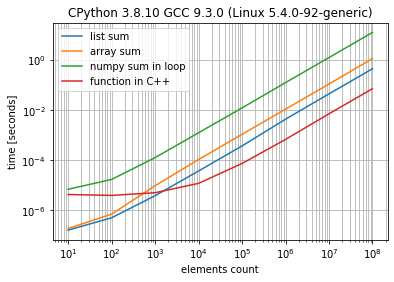

In [43]:
b.plot()

C Python функциями numpy работает медленней чем все остальные типы. Причина какая же как в array - создание python объекта при извлечении значения. 

Примерно до 10000 элементов функция, выполняющаяся на С++, имеет константное время выполнение и работает медленней всех, а потом уверенно лидирует. Это объясняется скоростью создания ndarray-я. 

In [44]:
L = list(range(10_000))
A = array.array('i', L)
NA = np.array(L)

In [45]:
len(L)

10000

In [46]:
%%timeit 
sum(L)

38 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
%%timeit 
sum(A)

107 µs ± 208 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
%%timeit 
sum(NA)

634 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Финальный тест

In [49]:
%%timeit 
NA.sum() # Выполняется в С++

8.17 µs ± 27 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Просто за счет того, что функция написана на С++, мы получили примерно четырех кратный прирост производительности. 

### Вывод

Numpy был разработан специально для манипуляции большими массивами данных. Все математические операции для ndarray реализованы на С. Из — за создания Python объектов циклы с эти типами данных работают очень медленно и следует их избегать. 

Может показаться что существенный прирост производительности можно добиться распараллелив ndarray и применив векторизацию (SIMD инструкции). В следующей главе мы подробно изучим этот вопрос.

## Распараллеливаем Numpy ndarray

<a href="https://scipy-cookbook.readthedocs.io/items/ParallelProgramming.html">Ссылка на источник</a>

В Numpy реализована поддержка библиотек линейной алгебры, которые в свою очередь реализуют SIMD инструкций и много поточность (см <a href="https://habr.com/ru/post/274331/">здесь</a>). Можно посмотреть какую версию библиотеки поддерживает локальна версия numpy. 

In [50]:
print(np.__config__.show())

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
None


В моем случаи это openblas

Следовательно реализованные функции для линейной алгебры будут работать параллельно из коробки (см <a href="https://numpy.org/doc/stable/reference/routines.linalg.html">список функций</a>)